In [3]:
import numpy as np
import pandas as pd
from joblib import dump
from sklearn.preprocessing import RobustScaler, MinMaxScaler
import seaborn as sns
from utils.query_snowflake import query_snowflake_pd



In [60]:
df = query_snowflake_pd(
    '''
with nm as (
SELECT * 
FROM (
    SELECT nm.address_id, nm.swimming_pool_present, 
           ROW_NUMBER() OVER (PARTITION BY nm.address_id ORDER BY nm.capture_date) AS row_num
    FROM PRODDOMAINDW.NEARMAP.NEARMAP_PROPERTY nm
) t
WHERE t.row_num = 1
),

bagg as (
SELECT * 
FROM (
    SELECT svp_address_id, nm_clipped, arx_building_size,
           ROW_NUMBER() OVER (PARTITION BY bagg.svp_address_id ORDER BY nm_clipped desc) AS row_num
    FROM zz_erfan_moshiri_dev.property_type.building_size_aggr bagg
) t
WHERE t.row_num = 1
),

groups as (
select adds.postcode, adds.street_name, adds.street_type_code, adds.number_first,
count(*) as count
from  property_data.property_base.psma_gnaf_denorm_address_detail Adds
join PRODDOMAINDW.DATAMART.DATASOURCE_PACMAN_PROPERTY_PROFILE a on Adds.ADDRESS_DETAIL_PID = a.psma_key
where FILE_DATE = '202405Q2'
group by adds.postcode, adds.street_name, adds.street_type_code, adds.number_first

),
sellection as (

select 
CAST(adds.postcode AS INT) as postcode_int, adds.postcode, adds.street_name, adds.street_type_code, adds.number_first, adds.flat_number,
a.svp_address_id, a.psma_key, groups.count,
lagg.land_area, 

CASE
    when bagg.nm_clipped is not null then bagg.nm_clipped
    when bagg.arx_building_size is not null then bagg.arx_building_size
    else null
end as building_size,

adagg.roof_height, adagg.roof_shape,
nm.swimming_pool_present as has_pool,
adagg.pp_property_type as property_type,
adagg.planning_zone 
from property_data.property_base.psma_gnaf_denorm_address_detail Adds
 
join PRODDOMAINDW.DATAMART.DATASOURCE_PACMAN_PROPERTY_PROFILE a on Adds.ADDRESS_DETAIL_PID = a.psma_key
join zz_erfan_moshiri_dev.property_type.land_area_aggr lagg on lagg.SVP_address_id = a.svp_address_id
join bagg on bagg.SVP_address_id = a.svp_address_id
join zz_erfan_moshiri_dev.property_type.address_features_aggr adagg on adagg.SVP_address_id = a.svp_address_id
join nm on nm.address_id = a.psma_key
join groups using (postcode, street_name, street_type_code, number_first)

where property_type = adagg.cl_property_type
and nm.address_id is not null
and a.svp_address_id is not null
and FILE_DATE = '202405Q2'
and lagg.land_area > 10 and (lagg.avg_diff / lagg.land_area) < 0.2
and building_size > 5
and lagg.land_area > building_size
and property_type != 'UNKNOWN'
)
select *
from sellection
where postcode >= 2000 and postcode < 3000
;

    '''
    , role="ROLE_PROPERTY_DATA_RESTRICTED")

In [62]:
df['COUNT'].value_counts()

COUNT
1      1450497
2        18818
3        12532
4         3067
5         2696
        ...   
188          1
565          1
167          1
249          1
435          1
Name: count, Length: 225, dtype: int64

In [5]:
df_dist = pd.read_hdf('new/nearest_dist.x')
df_dist

SVP_ADDRESS_ID  LAND_AREA POSTCODE        LON       LAT  \
POSTCODE                                                                   
0800     5816        UU-9880-HS     1235.0     0800  130.83514 -12.45824   
         7761        DV-9861-LC     3876.8     0800  130.84266 -12.46082   
         8981        RY-5215-MA      745.0     0800  130.84335 -12.46218   
         25773       DI-8625-IG      944.0     0800  130.83937 -12.46022   
         28879       AB-7343-TZ        NaN     0800  130.83969 -12.46113   
...                         ...        ...      ...        ...       ...   
7470     8565063     AK-5427-XQ      357.0     7470  145.52413 -41.77410   
         8566425     IA-8753-UR      890.0     7470  145.52451 -41.77222   
         8584479     ZU-5347-DL     5311.0     7470  145.52554 -41.78996   
         8586452     JW-5070-UB      593.0     7470  145.53795 -41.78466   
         8596871     JS-7852-YP      244.0     7470  145.53969 -41.78004   

                   next1   next2     dist1     dist2  
POSTCODE                                              
0800     5816     1239.3  1075.3  0.000361  0.000437  
         7761      969.0  1020.0  0.000224  0.000320  
         8981      128.0  1911.8  0.000503  0.000772  
         25773     702.8   944.3  0.000304  0.000453  
         28879       NaN     NaN  0.000000  0.000000  
...                  ...     ...       ...       ...  
7470     8565063   331.0   871.0  0.000170  0.000214  
         8566425   410.0   879.0  0.000259  0.000341  
         8584479  5311.0   959.0  0.000513  0.001303  
         8586452   507.0  1356.0  0.000212  0.000220  
         8596871   638.0  1028.0  0.000226  0.000255  

[8609362 rows x 9 columns]

In [63]:
df1 = pd.merge(df, df_dist[['SVP_ADDRESS_ID', 'next1', 'next2', 'dist1', 'dist2']], on=['SVP_ADDRESS_ID'], how='left')

df1[['next1', 'next2', 'dist1', 'dist2']] = df1.groupby(
    ['POSTCODE', 'STREET_NAME', 'STREET_TYPE_CODE','NUMBER_FIRST']
)[['next1', 'next2', 'dist1', 'dist2']].transform(lambda x: x.ffill().bfill())

df1.shape

(1503413, 20)

In [67]:
df1

,POSTCODE_INT,POSTCODE,STREET_NAME,STREET_TYPE_CODE,NUMBER_FIRST,FLAT_NUMBER,SVP_ADDRESS_ID,PSMA_KEY,COUNT,LAND_AREA,BUILDING_SIZE,ROOF_HEIGHT,ROOF_SHAPE,HAS_POOL,PROPERTY_TYPE,PLANNING_ZONE,next1,next2,dist1,dist2
0,2076,2076,TWICKENHAM,CLOSE,14,None,VH-7610-IU,GANSW705527481,1,852.1,164.6,3.747500,0.750000,False,House,Residential,967.8,870.9,0.000157,0.000170
1,2021,2021,GLENVIEW,STREET,17,None,GO-8994-UB,GANSW705606147,1,178.4,72.1,4.885714,0.857143,True,House,Residential,173.7,177.8,0.000054,0.000063
2,2779,2779,OAKLANDS,ROAD,16A,None,DM-6245-DJ,GANSW716739053,1,816.2,196.8,6.670000,0.000000,False,House,None,753.8,883.3,0.000146,0.000282
3,2226,2226,GEORGES RIVER,ROAD,108,None,HJ-7590-OD,GANSW704998860,1,553.5,181.8,3.497500,0.000000,False,House,Residential,558.8,575.1,0.000125,0.000130
4,2769,2769,BLACKHEATH,STREET,15,None,ZY-2645-TT,GANSW718765866,1,370.3,181.6,7.810000,0.000000,True,House,Residential,372.1,387.9,0.000141,0.000260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1503408,2114,2114,MARLOW,AVENUE,12,None,AR-0776-FW,GANSW704577036,1,737.2,248.8,8.410000,0.000000,False,House,Residential,789.7,2245.7,0.000170,0.000256
1503409,2640,2640,YAMBLA,PLACE,751,None,HW-2687-RT,GANSW703894754,1,836.7,256.1,8.290000,0.000000,False,House,Residential,848.2,821.2,0.000215,0.000283
1503410,2502,2502,LACKAWANNA,STREET,25,None,BJ-8841-OV,GANSW704510815,1,445.9,180.8,7.260000,0.000000,False,House,Residential,446.0,446.2,0.000130,0.000139
1503411,2154,2154,CHILTERN,CRESCENT,11,None,EI-7557-LZ,GANSW704377931,1,926.4,285.1,4.970000,0.000000,False,House,Residential,1003.6,919.9,0.000252,0.000347


In [66]:
df1['PROPERTY_TYPE'].value_counts()

PROPERTY_TYPE
House                              1481030
Apartment/Unit                       13127
Rural/Farming                         4762
Townhouse                             3981
Business/Commercial                    378
Development/Land                        77
Factory, Warehouse & Industrial         58
Name: count, dtype: int64

In [65]:
df1.to_hdf('new/raw_featureset.x', key='s')

/var/folders/bl/bhxc9rps0xsb8c84q3j7djcc0000gp/T/ipykernel_94793/809741990.py:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['POSTCODE_INT', 'POSTCODE', 'STREET_NAME', 'STREET_TYPE_CODE',
       'NUMBER_FIRST', 'FLAT_NUMBER', 'SVP_ADDRESS_ID', 'PSMA_KEY',
       'PROPERTY_TYPE', 'PLANNING_ZONE'],
      dtype='object')]

  df1.to_hdf('new/raw_featureset.x', key='s')


In [7]:
df1 = pd.read_hdf('new/raw_featureset.x')

In [9]:
print(df1.shape)
df1.columns

(1503413, 20)


Index(['POSTCODE_INT', 'POSTCODE', 'STREET_NAME', 'STREET_TYPE_CODE',
       'NUMBER_FIRST', 'FLAT_NUMBER', 'SVP_ADDRESS_ID', 'PSMA_KEY', 'COUNT',
       'LAND_AREA', 'BUILDING_SIZE', 'ROOF_HEIGHT', 'ROOF_SHAPE', 'HAS_POOL',
       'PROPERTY_TYPE', 'PLANNING_ZONE', 'next1', 'next2', 'dist1', 'dist2'],
      dtype='object')

<Axes: xlabel='dist1'>

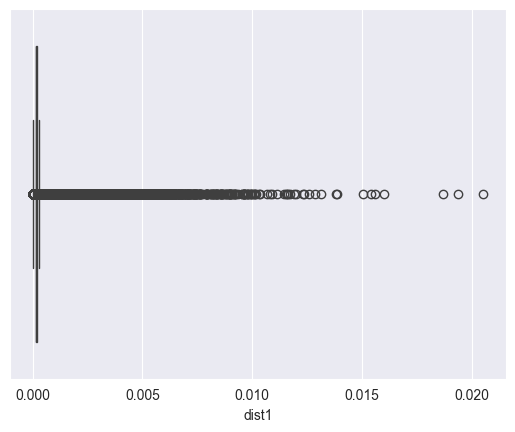

In [10]:
sns.boxplot(x=df1['dist1']) 
# df1['next1'].mean()
# sns.boxplot(x=df1[df1['next1'] < 2000]['next1'])

In [11]:
df1.loc[df1['COUNT'] > 200, 'COUNT'] = 200
df1.loc[df1['LAND_AREA'] > 10000, 'LAND_AREA'] = 10000
df1.loc[df1['BUILDING_SIZE'] > 4000, 'BUILDING_SIZE'] = 4000
df1.loc[df1['ROOF_HEIGHT'] > 60, 'ROOF_HEIGHT'] = 60

df1.loc[df1['next1'] > 10000, 'next1'] = 10000
df1.loc[df1['next2'] > 10000, 'next2'] = 10000
df1.loc[df1['dist1'] > 0.005, 'dist1'] = 0.005
df1.loc[df1['dist2'] > 0.005, 'dist2'] = 0.005

In [12]:
df1.isnull().sum()

POSTCODE_INT              0
POSTCODE                  0
STREET_NAME               0
STREET_TYPE_CODE          0
NUMBER_FIRST              0
FLAT_NUMBER         1500680
SVP_ADDRESS_ID            0
PSMA_KEY                  0
COUNT                     0
LAND_AREA                 0
BUILDING_SIZE             0
ROOF_HEIGHT           11140
ROOF_SHAPE             3631
HAS_POOL                  0
PROPERTY_TYPE             0
PLANNING_ZONE          8484
next1                 39204
next2                 43355
dist1                 30148
dist2                 30148
dtype: int64

In [13]:
df3 = df1[(df1['POSTCODE_INT'] < 2200) & (df1['POSTCODE_INT'] > 2170)]
# df3
df2 = df3.dropna(subset=['dist1', 'dist2', 'next1', 'next2', 'ROOF_HEIGHT', 'ROOF_SHAPE', 'PLANNING_ZONE'])
df2.isnull().sum()


POSTCODE_INT            0
POSTCODE                0
STREET_NAME             0
STREET_TYPE_CODE        0
NUMBER_FIRST            0
FLAT_NUMBER         54802
SVP_ADDRESS_ID          0
PSMA_KEY                0
COUNT                   0
LAND_AREA               0
BUILDING_SIZE           0
ROOF_HEIGHT             0
ROOF_SHAPE              0
HAS_POOL                0
PROPERTY_TYPE           0
PLANNING_ZONE           0
next1                   0
next2                   0
dist1                   0
dist2                   0
dtype: int64

In [14]:
df2

,POSTCODE_INT,POSTCODE,STREET_NAME,STREET_TYPE_CODE,NUMBER_FIRST,FLAT_NUMBER,SVP_ADDRESS_ID,PSMA_KEY,COUNT,LAND_AREA,BUILDING_SIZE,ROOF_HEIGHT,ROOF_SHAPE,HAS_POOL,PROPERTY_TYPE,PLANNING_ZONE,next1,next2,dist1,dist2
22,2171,2171,CARMICHAEL,DRIVE,64,None,BX-9215-SE,GANSW706268417,1,544.6,262.3,4.415000,0.500000,False,House,Residential,542.5,572.2,0.000141,0.000141
26,2171,2171,RAINHAM,CIRCUIT,7,None,XB-0318-SY,GANSW706288363,1,500.6,173.3,8.310000,0.000000,False,House,Residential,300.8,495.7,0.000170,0.000172
54,2178,2178,WESTERN,ROAD,130,None,DK-9400-TP,GANSW705059193,1,10000.0,591.5,3.581111,0.666667,False,House,Rural/Primary Production,10000.0,10000.0,0.000671,0.001611
55,2171,2171,SPENCER,ROAD,135,None,YX-4429-CA,GANSW718702483,1,314.0,168.7,5.058000,0.000000,False,House,Residential,295.6,383.2,0.000081,0.000161
85,2171,2171,COFFS HARBOUR,AVENUE,54,None,LG-6450-BN,GANSW717063199,1,283.5,128.0,7.522500,1.000000,False,House,Residential,223.2,267.1,0.000092,0.000134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1503332,2176,2176,LACHLAN,STREET,19,None,IM-1204-BR,GANSW704204305,1,686.8,315.6,5.960000,0.000000,False,House,Residential,768.8,690.0,0.000245,0.000269
1503345,2176,2176,MIAMI,CLOSE,4,None,VW-0911-NO,GANSW706619346,1,550.4,168.3,3.370000,0.666667,False,House,Residential,572.4,549.9,0.000157,0.000247
1503352,2195,2195,CHALMERS,STREET,60,None,YT-0925-RP,GANSW705156944,1,538.6,268.6,3.806000,0.600000,False,House,Residential,274.8,592.8,0.000143,0.000150
1503366,2176,2176,BRUNSWICK,CRESCENT,25,None,FB-1226-QO,GANSW705978080,1,790.0,421.4,5.495000,0.500000,True,House,Residential,618.9,540.6,0.000158,0.000194


In [15]:
df2['PROPERTY_TYPE'].value_counts()

PROPERTY_TYPE
House                              53977
Apartment/Unit                       649
Townhouse                            145
Rural/Farming                         19
Factory, Warehouse & Industrial        6
Business/Commercial                    4
Development/Land                       2
Name: count, dtype: int64

In [16]:
df2 

,POSTCODE_INT,POSTCODE,STREET_NAME,STREET_TYPE_CODE,NUMBER_FIRST,FLAT_NUMBER,SVP_ADDRESS_ID,PSMA_KEY,COUNT,LAND_AREA,BUILDING_SIZE,ROOF_HEIGHT,ROOF_SHAPE,HAS_POOL,PROPERTY_TYPE,PLANNING_ZONE,next1,next2,dist1,dist2
22,2171,2171,CARMICHAEL,DRIVE,64,None,BX-9215-SE,GANSW706268417,1,544.6,262.3,4.415000,0.500000,False,House,Residential,542.5,572.2,0.000141,0.000141
26,2171,2171,RAINHAM,CIRCUIT,7,None,XB-0318-SY,GANSW706288363,1,500.6,173.3,8.310000,0.000000,False,House,Residential,300.8,495.7,0.000170,0.000172
54,2178,2178,WESTERN,ROAD,130,None,DK-9400-TP,GANSW705059193,1,10000.0,591.5,3.581111,0.666667,False,House,Rural/Primary Production,10000.0,10000.0,0.000671,0.001611
55,2171,2171,SPENCER,ROAD,135,None,YX-4429-CA,GANSW718702483,1,314.0,168.7,5.058000,0.000000,False,House,Residential,295.6,383.2,0.000081,0.000161
85,2171,2171,COFFS HARBOUR,AVENUE,54,None,LG-6450-BN,GANSW717063199,1,283.5,128.0,7.522500,1.000000,False,House,Residential,223.2,267.1,0.000092,0.000134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1503332,2176,2176,LACHLAN,STREET,19,None,IM-1204-BR,GANSW704204305,1,686.8,315.6,5.960000,0.000000,False,House,Residential,768.8,690.0,0.000245,0.000269
1503345,2176,2176,MIAMI,CLOSE,4,None,VW-0911-NO,GANSW706619346,1,550.4,168.3,3.370000,0.666667,False,House,Residential,572.4,549.9,0.000157,0.000247
1503352,2195,2195,CHALMERS,STREET,60,None,YT-0925-RP,GANSW705156944,1,538.6,268.6,3.806000,0.600000,False,House,Residential,274.8,592.8,0.000143,0.000150
1503366,2176,2176,BRUNSWICK,CRESCENT,25,None,FB-1226-QO,GANSW705978080,1,790.0,421.4,5.495000,0.500000,True,House,Residential,618.9,540.6,0.000158,0.000194


In [17]:
df2['FLAT_NUMBER'] = df2['FLAT_NUMBER'].notna()

/var/folders/bl/bhxc9rps0xsb8c84q3j7djcc0000gp/T/ipykernel_34072/1754783521.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['FLAT_NUMBER'] = df2['FLAT_NUMBER'].notna()


In [18]:
df2.columns

Index(['POSTCODE_INT', 'POSTCODE', 'STREET_NAME', 'STREET_TYPE_CODE',
       'NUMBER_FIRST', 'FLAT_NUMBER', 'SVP_ADDRESS_ID', 'PSMA_KEY', 'COUNT',
       'LAND_AREA', 'BUILDING_SIZE', 'ROOF_HEIGHT', 'ROOF_SHAPE', 'HAS_POOL',
       'PROPERTY_TYPE', 'PLANNING_ZONE', 'next1', 'next2', 'dist1', 'dist2'],
      dtype='object')

In [19]:
df2 = df2[['POSTCODE_INT', 'POSTCODE', 'STREET_NAME', 'STREET_TYPE_CODE',
            'NUMBER_FIRST', 'SVP_ADDRESS_ID', 'PSMA_KEY',
           
            'COUNT', 'LAND_AREA', 'BUILDING_SIZE', 'ROOF_HEIGHT', 'ROOF_SHAPE', 'next1', 'next2', 'dist1', 'dist2',
           
            'FLAT_NUMBER', 'HAS_POOL', 'PROPERTY_TYPE', 'PLANNING_ZONE',]]

In [20]:
columns_normalize = [
    'COUNT', 'LAND_AREA', 'BUILDING_SIZE', 'ROOF_HEIGHT', 'ROOF_SHAPE', 'next1', 'next2', 'dist1', 'dist2'
]

columns_onehot = [
    'FLAT_NUMBER', 'HAS_POOL', 'PROPERTY_TYPE', 'PLANNING_ZONE'
]

scaler = MinMaxScaler()
df2[columns_normalize] = scaler.fit_transform(df2[columns_normalize])
dump(scaler, 'new/scaler.pkl')

df2 = pd.get_dummies(df2, columns=columns_onehot)

df2

,POSTCODE_INT,POSTCODE,STREET_NAME,STREET_TYPE_CODE,NUMBER_FIRST,SVP_ADDRESS_ID,PSMA_KEY,COUNT,LAND_AREA,BUILDING_SIZE,...,PLANNING_ZONE_Commercial/Business,PLANNING_ZONE_Community Use,PLANNING_ZONE_Conservation/National Park,PLANNING_ZONE_Industrial/Utilities,PLANNING_ZONE_Mixed Use,PLANNING_ZONE_Recreational/Open Space,PLANNING_ZONE_Residential,PLANNING_ZONE_Rural/Primary Production,PLANNING_ZONE_Special Use,PLANNING_ZONE_Transport/Infrastructure
22,2171,2171,CARMICHAEL,DRIVE,64,BX-9215-SE,GANSW706268417,0.0,0.046412,0.060997,...,False,False,False,False,False,False,True,False,False,False
26,2171,2171,RAINHAM,CIRCUIT,7,XB-0318-SY,GANSW706288363,0.0,0.041974,0.038638,...,False,False,False,False,False,False,True,False,False,False
54,2178,2178,WESTERN,ROAD,130,DK-9400-TP,GANSW705059193,0.0,1.000000,0.143701,...,False,False,False,False,False,False,False,True,False,False
55,2171,2171,SPENCER,ROAD,135,YX-4429-CA,GANSW718702483,0.0,0.023155,0.037483,...,False,False,False,False,False,False,True,False,False,False
85,2171,2171,COFFS HARBOUR,AVENUE,54,LG-6450-BN,GANSW717063199,0.0,0.020079,0.027258,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1503332,2176,2176,LACHLAN,STREET,19,IM-1204-BR,GANSW704204305,0.0,0.060753,0.074388,...,False,False,False,False,False,False,True,False,False,False
1503345,2176,2176,MIAMI,CLOSE,4,VW-0911-NO,GANSW706619346,0.0,0.046997,0.037382,...,False,False,False,False,False,False,True,False,False,False
1503352,2195,2195,CHALMERS,STREET,60,YT-0925-RP,GANSW705156944,0.0,0.045807,0.062580,...,False,False,False,False,False,False,True,False,False,False
1503366,2176,2176,BRUNSWICK,CRESCENT,25,FB-1226-QO,GANSW705978080,0.0,0.071161,0.100967,...,False,False,False,False,False,False,True,False,False,False


In [21]:
df2 = df2.sort_values(by=['POSTCODE', 'STREET_NAME', 'STREET_TYPE_CODE', 'NUMBER_FIRST'])
df2

,POSTCODE_INT,POSTCODE,STREET_NAME,STREET_TYPE_CODE,NUMBER_FIRST,SVP_ADDRESS_ID,PSMA_KEY,COUNT,LAND_AREA,BUILDING_SIZE,...,PLANNING_ZONE_Commercial/Business,PLANNING_ZONE_Community Use,PLANNING_ZONE_Conservation/National Park,PLANNING_ZONE_Industrial/Utilities,PLANNING_ZONE_Mixed Use,PLANNING_ZONE_Recreational/Open Space,PLANNING_ZONE_Residential,PLANNING_ZONE_Rural/Primary Production,PLANNING_ZONE_Special Use,PLANNING_ZONE_Transport/Infrastructure
1613,2171,2171,ADDISON,WAY,10,WC-7494-SH,GANSW706264860,0.0,0.050093,0.071122,...,False,False,False,False,False,False,True,False,False,False
114017,2171,2171,ADDISON,WAY,12,SS-2664-TE,GANSW706264861,0.0,0.049911,0.062379,...,False,False,False,False,False,False,True,False,False,False
114016,2171,2171,ADDISON,WAY,6,SR-7976-AN,GANSW706278307,0.0,0.049367,0.062706,...,False,False,False,False,False,False,True,False,False,False
114015,2171,2171,ADDISON,WAY,8,SS-0962-ZY,GANSW706278308,0.0,0.050093,0.062605,...,False,False,False,False,False,False,True,False,False,False
1284335,2171,2171,ADELAIDE,PLACE,1,AI-0725-XP,GANSW704368812,0.0,0.078371,0.111594,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374048,2199,2199,YEO,STREET,50,MI-0950-DY,GANSW706353720,0.0,0.047037,0.025725,...,False,False,False,False,False,False,True,False,False,False
103858,2199,2199,YEO,STREET,6,AT-3903-CZ,GANSW706353721,0.0,0.043437,0.040774,...,False,False,False,False,False,False,True,False,False,False
1101720,2199,2199,YEO,STREET,7,AV-8878-VA,GANSW706353722,0.0,0.052967,0.036126,...,False,False,False,False,False,False,True,False,False,False
1233101,2199,2199,YEO,STREET,8,YQ-2697-CY,GANSW706353723,0.0,0.043437,0.039266,...,False,False,False,False,False,False,True,False,False,False


In [25]:
g = df2.groupby(['POSTCODE', 'STREET_NAME', 'STREET_TYPE_CODE']).size()
# sns.boxplot(g)
# g.mean()

19.371509367267585

In [26]:
df2 = df2.drop(columns=['POSTCODE_INT', 'POSTCODE', 'STREET_NAME', 'STREET_TYPE_CODE',
            'NUMBER_FIRST', 'SVP_ADDRESS_ID', 'PSMA_KEY'])
df2

,COUNT,LAND_AREA,BUILDING_SIZE,ROOF_HEIGHT,ROOF_SHAPE,next1,next2,dist1,dist2,FLAT_NUMBER_False,...,PLANNING_ZONE_Commercial/Business,PLANNING_ZONE_Community Use,PLANNING_ZONE_Conservation/National Park,PLANNING_ZONE_Industrial/Utilities,PLANNING_ZONE_Mixed Use,PLANNING_ZONE_Recreational/Open Space,PLANNING_ZONE_Residential,PLANNING_ZONE_Rural/Primary Production,PLANNING_ZONE_Special Use,PLANNING_ZONE_Transport/Infrastructure
1613,0.0,0.050093,0.071122,0.247940,0.000000,0.058016,0.057836,0.041511,0.033287,True,...,False,False,False,False,False,False,True,False,False,False
114017,0.0,0.049911,0.062379,0.254610,0.000000,0.032223,0.058016,0.039616,0.033287,True,...,False,False,False,False,False,False,True,False,False,False
114016,0.0,0.049367,0.062706,0.295018,1.000000,0.058016,0.059926,0.043545,0.046043,True,...,False,False,False,False,False,False,True,False,False,False
114015,0.0,0.050093,0.062605,0.222048,1.000000,0.058016,0.057296,0.041511,0.034409,True,...,False,False,False,False,False,False,True,False,False,False
1284335,0.0,0.078371,0.111594,0.275402,0.000000,0.084518,0.074517,0.043101,0.037202,True,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374048,0.0,0.047037,0.025725,0.145547,0.000000,0.061236,0.061236,0.033768,0.055317,True,...,False,False,False,False,False,False,True,False,False,False
103858,0.0,0.043437,0.040774,0.075193,0.333333,0.051405,0.051415,0.028297,0.024739,True,...,False,False,False,False,False,False,True,False,False,False
1101720,0.0,0.052967,0.036126,0.123186,0.500000,0.061206,0.030533,0.030791,0.024331,True,...,False,False,False,False,False,False,True,False,False,False
1233101,0.0,0.043437,0.039266,0.098862,0.000000,0.051415,0.051415,0.028297,0.024739,True,...,False,False,False,False,False,False,True,False,False,False


In [27]:
df2.to_hdf('new/processed_data_small.x', key='s')

In [4]:
df2 = pd.read_hdf('new/processed_data_small.x')

In [5]:
df2.describe()

,COUNT,LAND_AREA,BUILDING_SIZE,ROOF_HEIGHT,ROOF_SHAPE,next1,next2,dist1,dist2
count,54802.000000,54802.000000,54802.000000,54802.000000,54802.000000,54802.000000,54802.000000,54802.000000,54802.000000
mean,0.001763,0.057992,0.056485,0.135076,0.313332,0.063619,0.067332,0.038032,0.039241
std,0.016128,0.097473,0.028867,0.070988,0.311748,0.095250,0.094798,0.024718,0.027452
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.038303,0.042030,0.081797,0.000000,0.044904,0.047945,0.029516,0.028071
50%,0.000000,0.047693,0.053837,0.116909,0.333333,0.055006,0.055846,0.036238,0.034928
75%,0.000000,0.054823,0.065821,0.171047,0.500000,0.061186,0.064406,0.043545,0.044944
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
df4 = pd.read_hdf('log_minmax_clean_df_sorted.hdf')
df4.describe()

,CL_FLOOR_AREA,NEARMAP_PARCEL_AREA_SQM,NEARMAP_BUILDING_COUNT,NEARMAP_BUILDING_TOTAL_AREA_SQM,BUILDING_SIZE,TOTAL_BUILDING_SIZE,ROOF_HEIGHT,EAVE_HEIGHT,ESTIMATED_LEVELS,AVG_BED,...,PRIMARY_ROOF_MATERIAL_METAL,PRIMARY_ROOF_MATERIAL_TILE,ROOF_SHAPE_-1,ROOF_SHAPE_FLAT,ROOF_SHAPE_GABLED,ROOF_SHAPE_HIPPED,ROOF_SHAPE_MANSARD,ROOF_SHAPE_MIXED,ROOF_SHAPE_OTHER,ROOF_SHAPE_SHED
count,303942.000000,303942.000000,303942.000000,303942.000000,303942.000000,303942.000000,303942.000000,303942.000000,303942.000000,303942.000000,...,303942.000000,303942.000000,303942.000000,303942.000000,303942.000000,303942.000000,303942.000000,303942.000000,303942.000000,303942.000000
mean,0.664394,0.452144,0.262771,0.605711,0.598864,0.600256,0.319471,0.297275,0.032550,0.529336,...,0.362418,0.602668,0.310135,0.081206,0.031197,0.569622,0.000115,0.007663,0.000007,0.000056
std,0.061208,0.077278,0.071726,0.072172,0.068580,0.071699,0.050013,0.055773,0.054820,0.074829,...,0.480699,0.489347,0.462549,0.273152,0.173849,0.495130,0.010730,0.087201,0.002565,0.007479
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.628436,0.413757,0.231378,0.570557,0.569664,0.566092,0.287600,0.260259,0.000000,0.507795,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.664953,0.450769,0.231378,0.599373,0.611754,0.594875,0.311132,0.285410,0.000000,0.507795,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,0.701834,0.475086,0.231378,0.639476,0.639703,0.630673,0.353665,0.331250,0.108138,0.589531,...,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
df4

,CL_FLOOR_AREA,NEARMAP_PARCEL_AREA_SQM,NEARMAP_BUILDING_COUNT,NEARMAP_BUILDING_TOTAL_AREA_SQM,BUILDING_SIZE,TOTAL_BUILDING_SIZE,ROOF_HEIGHT,EAVE_HEIGHT,ESTIMATED_LEVELS,AVG_BED,...,"PP_PROPERTY_TYPE_CATEGORY_Factory, Warehouse & Industrial",PP_PROPERTY_TYPE_CATEGORY_House,PP_PROPERTY_TYPE_CATEGORY_Other Residential,PP_PROPERTY_TYPE_CATEGORY_Rural/Farming,PP_PROPERTY_TYPE_CATEGORY_Townhouse,PP_PROPERTY_TYPE_CATEGORY_UNKNOWN,CL_PROPERTY_TYPE_CATEGORY_Apartment/Unit,CL_PROPERTY_TYPE_CATEGORY_House,CL_PROPERTY_TYPE_CATEGORY_Rural/Farming,CL_PROPERTY_TYPE_CATEGORY_Townhouse
300885,0.673876,0.515618,0.366726,0.753616,0.690969,0.743608,0.823344,0.829165,0.673617,0.507795,...,False,True,False,False,False,False,True,False,False,False
324593,0.594527,0.548744,0.231378,0.737078,0.781978,0.738713,0.668862,0.679775,0.454660,0.335634,...,False,True,False,False,False,False,True,False,False,False
144893,0.609410,0.633682,0.366726,0.929586,0.924883,0.891271,0.549541,0.564386,0.334114,0.402418,...,False,True,False,False,False,False,True,False,False,False
319248,0.645060,0.501405,0.231378,0.886275,0.747209,0.888240,0.541206,0.556326,0.334114,0.402418,...,False,False,False,False,False,False,True,False,False,False
321042,0.645060,0.559219,0.231378,0.696695,0.751033,0.698240,0.481456,0.498545,0.244377,0.253897,...,False,False,True,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178177,0.585641,0.419596,0.231378,0.543078,0.585314,0.544283,0.337486,0.226444,0.000000,0.402418,...,False,False,False,False,False,False,True,False,False,False
357915,0.613193,0.432401,0.231378,0.544473,0.586938,0.545680,0.378683,0.332690,0.108138,0.402418,...,False,True,False,False,False,False,True,False,False,False
351076,0.677741,0.485178,0.366726,0.592307,0.627993,0.583849,0.380726,0.226444,0.108138,0.402418,...,False,False,False,False,False,False,False,True,False,False
246123,0.721969,0.725590,0.537244,0.667383,0.648041,0.602488,0.300830,0.290915,0.000000,0.589531,...,False,False,False,True,False,False,False,True,False,False
